# Role Classifier AI
This notebook contains AI model that is able to classify images into their roles (informative, decorative, functional, text, or complex). The model takes image and several text attributes as input and outputs a role.

## Load Data

In [1]:
# Install dependencies
%pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [11]:
import os
import json
import pandas as pd

# Define the path to the directory containing the JSON files
json_dir = "../scraper/output"

# Initialize empty lists to store the image links and textual contexts
srcs = []
file_names = []
roles = []
alts = []
attrs = []
a_button_parents = []
previous_texts = []
next_texts = []
textual_contexts = []

images = []

# Loop through each JSON file in the directory
for filename in os.listdir(json_dir):
    if filename.endswith(".json"):
        # Read the JSON file
        with open(os.path.join(json_dir, filename), "r") as file:
            data = json.load(file)
        
        # Extract the image link and textual context from the JSON data
        whole_text = data["text"]
        sub_images = data["images"]

        images.extend(sub_images)

        for image in images:
            # {
            #     "src": "http://donutworrybehappy.eu/getattachment/71afc349-9d82-4861-9324-1d304061f188/hero-section.aspx",
            #     "file_name": "./images/donutworrybehappy.eu/image_12.jpg",
            #     "role": "text",
            #     "alt": "Strawjelly Jam: fresh strawberry-style glaze with Belgian chocolate cover",
            #     "attrs": {
            #         "src": "/getattachment/71afc349-9d82-4861-9324-1d304061f188/hero-section.aspx?",
            #         "class": [
            #             "StyledMobileImage-sc-y8dlz5",
            #             "cZQlpK"
            #         ]
            #     },
            #     "a_button_parent": "None",
            #     "previous_text": "",
            #     "next_text": "Donut Worry Be Happy"
            # }
            src = image["src"]
            file_name = image["file_name"]
            role = image["role"]
            alt = image["alt"]
            attr = image["attrs"]
            a_button_parent = image["a_button_parent"]
            previous_text = image["previous_text"]
            next_text = image["next_text"]
            textual_context = whole_text
            
            # Append the image link and textual context to the respective lists
            srcs.append(src)
            file_names.append(file_name)
            roles.append(role)
            alts.append(alt)
            attrs.append(attrs)
            a_button_parents.append(a_button_parent)
            previous_texts.append(previous_text)
            next_texts.append(next_text)
            textual_contexts.append(textual_context)

# Create a dataframe from the lists
df = pd.DataFrame(images)

# Display the number data points in the dataframe
print(f"Number of data points: {df.shape[0]}")

# Display the dataframe
df.head()

Number of data points: 57


,src,file_name,role,alt,attrs,a_button_parent,previous_text,next_text
0,https://kajabi-storefronts-production.kajabi-c...,./images/bnbbosses.com/image_1.jpg,text,"#ProtectTheChildren. ""As a doctor, lawyer, and...","{'class': ['image__image'], 'src': 'https://ka...","<a class=""image__link"" href=""https://americasf...","If you want the safe treatments for CoVID, the...",Looking for the Latest Tech & Tools for your B...
1,https://kajabi-storefronts-production.kajabi-c...,./images/bnbbosses.com/image_2.jpg,informative,"Money rolled tightly with an egg with ""IRA"" wr...","{'class': ['card__image'], 'src': 'https://kaj...","<a class=""card"" href=""/blog/what-is-a-self-dir...","Articles, Blogs, & Podcasts",What Is a Self-Directed IRA & Why You Need One
2,https://kajabi-storefronts-production.kajabi-c...,./images/bnbbosses.com/image_3.jpg,informative,"A husband and wife in a living room, the wife ...","{'class': ['card__image'], 'src': 'https://kaj...","<a class=""card"" href=""/blog/how-to-write-an-ef...","May 30, 2023",How to Write an Effective Listing for Your Pro...
3,https://kajabi-storefronts-production.kajabi-c...,./images/bnbbosses.com/image_4.jpg,informative,A black woman with curly hair holding money ov...,"{'class': ['image__image'], 'src': 'https://ka...","<a class=""image__link"" href=""https://www.bnbbo...",Affiliates share our wonderful products and se...,Go and Grow!
4,https://kajabi-storefronts-production.kajabi-c...,./images/bnbbosses.com/image_5.jpg,text,"#ProtectTheChildren. ""(Thousands} have died af...","{'class': ['image__image'], 'src': 'https://ka...","<a class=""image__link"" href=""https://americasf...","If you want the safe treatments for CoVID, the...",Looking for the Latest Tech & Tools for your B...


In [1]:
# installing some dependencies, CLIP was released in PyTorch
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

# Updated to use a more recent version of PyTorch that supports newer CUDA versions
if CUDA_version in ["10.0", "10.1"]:
    torch_version_suffix = f"+cu{CUDA_version.replace('.', '')}"
elif CUDA_version == "10.2":
    torch_version_suffix = "+cu102"
elif CUDA_version in ["11.0", "11.1", "11.2", "11.3"]:
    torch_version_suffix = "+cu113"  # Assuming cu113 is compatible with CUDA 11.x versions
else:
    torch_version_suffix = "+cu116"  # Defaulting to a newer CUDA version if none of the above match

# Updated PyTorch version to a more recent one that is likely to have the desired CUDA version available
pytorch_version = "1.13.0"  # Example of a more recent version, adjust as needed

torch_version_suffix = "+cu116"  # Your CUDA version suffix

# Choose a compatible torchvision version
torchvision_version = "0.14.0"  # Example compatible version, adjust based on compatibility

%pip install torch=={pytorch_version}{torch_version_suffix} torchvision=={torchvision_version}{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

import numpy as np
import torch

print("Torch version:", torch.__version__)

CUDA version: 11.5
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://download.pytorch.org/whl/torch_stable.html
DEPRECATION: The HTML index page being used (https://download.pytorch.org/whl/torch_stable.html) is not a proper HTML 5 document. This is in violation of PEP 503 which requires these pages to be well-formed HTML 5 documents. Please reach out to the owners of this index page, and ask them to update this index page to a valid HTML 5 document. pip 22.2 will enforce this behaviour change. Discussion can be found at https://github.com/pypa/pip/issues/10825
  Using cached https://download.pytorch.org/whl/cu116/torch-1.13.0%2Bcu116-cp310-cp310-linux_x86_64.whl (1983.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 2.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 2.3.1
    Uninstalling torch-2.3.1:
      Successfully uninstalled torch-2.3.1
  Attempting uninstall: 

/home/felinejtd/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# clone the CLIP repository
!git clone https://github.com/openai/CLIP.git

import sys
from pathlib import Path

try:
    clip_dir = Path(".").absolute() / "CLIP"
    sys.path.append(str(clip_dir))
    print(f"CLIP dir is: {clip_dir}")
except Exception as e:
    print(e)

import clip

Cloning into 'CLIP'...
remote: Enumerating objects: 256, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 256 (delta 126), reused 110 (delta 110), pack-reused 102
Receiving objects: 100% (256/256), 8.86 MiB | 3.30 MiB/s, done.
Resolving deltas: 100% (140/140), done.
CLIP dir is: /home/felinejtd/projects/itb/ta/image-alt-text-ai/role_classifier/CLIP


In [3]:
# Load pre-trained model
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)
print(f"Model dir: {os.path.expanduser('~/.cache/clip')}")

Model dir: /home/felinejtd/.cache/clip


In [4]:
# Target roles
class_names = sorted(["informative", "decorative", "functional", "text", "complex", "other"])
class_names

['complex', 'decorative', 'functional', 'informative', 'other', 'text']

In [5]:
class_captions = [f"An image depicting a {x} image" for x in class_names]
class_captions

['An image depicting a complex image',
 'An image depicting a decorative image',
 'An image depicting a functional image',
 'An image depicting a informative image',
 'An image depicting a other image',
 'An image depicting a text image']

In [6]:
text_input = clip.tokenize(class_captions).to(device)
print(f"Tokens shape: {text_input.shape}")

with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)
print(f"Text features shape: {text_features.shape}")

Tokens shape: torch.Size([6, 77])
Text features shape: torch.Size([6, 512])


# Prepare Images

In [7]:
# In order to display the image we will need to de-nonrmalize them
image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).to('cpu')
image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).to('cpu')

def denormalize_image(image: torch.Tensor) -> torch.Tensor:
    image *= image_std[:, None, None]
    image += image_mean[:, None, None]
    return image

In [8]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [12]:
dataset = ImageFolder(root="../scraper/images", transform=transform)
data_batches = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

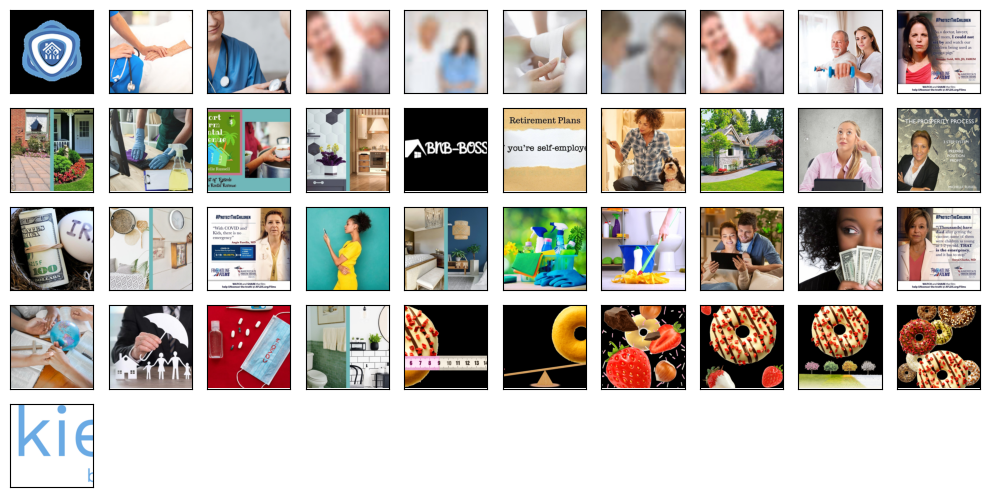

In [19]:
plt.figure(figsize=(10, 10))

# Show all images from the dataset since our dataset is small
try:
    for idx, (image, label_idx) in enumerate(dataset):
        # cur_class = class_names[label_idx]

            plt.subplot(10, 10, idx+1)
            plt.imshow(denormalize_image(image).permute(1, 2, 0))
            # plt.title(f"{cur_class}")
            plt.xticks([])
            plt.yticks([])
except Exception as e:
    pass

plt.tight_layout()

In [12]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image

# Load the CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Load and preprocess the image
image = Image.open("path/to/your/image.jpg")

# Prepare the text
text = "A description of the image"

# Preprocess the image and text
inputs = processor(text=[text], images=image, return_tensors="pt", padding=True)

# Encode the image and text
with torch.no_grad():
    outputs = model(**inputs)
    image_embeddings = outputs.image_embeds
    text_embeddings = outputs.text_embeds

# Normalize the embeddings
image_embeddings = image_embeddings / image_embeddings.norm(p=2, dim=-1, keepdim=True)
text_embeddings = text_embeddings / text_embeddings.norm(p=2, dim=-1, keepdim=True)

print("Image Embeddings:", image_embeddings)
print("Text Embeddings:", text_embeddings)

/home/felinejtd/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


FileNotFoundError: [Errno 2] No such file or directory: '/home/felinejtd/projects/itb/ta/image-alt-text-ai/role_classifier/path/to/your/image.jpg'